In [1]:
%cd ~/REVIVAL2

/disk2/fli/REVIVAL2


In [2]:
%load_ext blackcellmagic

In [3]:
import pandas as pd
import numpy as np
from glob import glob
from scipy.stats import spearmanr

from REVIVAL.util import get_file_name

/disk2/fli/miniconda3/envs/REVIVAL/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [4]:
# cols will be ev, af3, unweight ev + af3, weighted ev + af3, naive all, learned all

# navie ensemble 
ensemble_score = []

for f in sorted(glob("/disk2/fli/REVIVAL2/zs/comb/minimal/*.csv")):
    lib_name = get_file_name(f)
    if lib_name == "ParLQ":
        lib_name = "ParLQ-a"
    df = pd.read_csv(f, index_col=0)
    # put nan to 0
    df = df.fillna(0)

    # convert each column that is not fitness to ranking
    for c in df.columns:
        if c != "fitness":
            df[c] = df[c].rank()

    # navie ensemble for all
    y_true = df["fitness"].values

    # sum up all columns
    y_pred = df.drop(columns=["fitness"]).sum(axis=1)


    y_top2 = df[["EVmutation", "AF3"]].sum(axis=1)

    # save to dict
    ensemble_score.append(
        {
            "Library": lib_name,
            "EVmutation": spearmanr(y_true, df["EVmutation"].values)[0],
            "AF3": spearmanr(y_true, df["AF3"].values)[0],
            "EVmutation + AF3$_{uw}$": spearmanr(y_true, y_top2)[0],
            "All$_{uw}$": spearmanr(y_true, y_pred)[0],
        }
    )

In [ ]:
# ParLQ-f from lin_rho_pairwise_df for all
# Rma-CB from /disk2/fli/REVIVAL2/zs/lincomb/lin_params_EVmutation_AF3.npz

In [5]:
chosen_lib = "ParLQ-f"
intercept, weights = np.load("/disk2/fli/REVIVAL2/zs/lincomb/lin_params.npz", allow_pickle=True)[f"train_fold_{chosen_lib}_test_fold_{chosen_lib}"]
intercept, weights 

(26.161200618131705,
 array([-6.17606913, 10.66979437, -7.7613554 ,  6.01554364, -3.66054528,
        -2.79707653,  1.52553801, -1.14420113,  2.39054622,  2.18857787,
         4.07049746,  0.12910479,  2.13006802,  1.520902  , -0.41676693,
         2.28120538]))

In [6]:

from sklearn.preprocessing import StandardScaler

# use given weights to predict all

def inference_linear_model(X, w_0, w):
    y = np.dot(X, w) + w_0
    return y

In [7]:

FINAL_COL_ORDER = [
    "Library",
    "Hamming distance",
    "EVmutation",
    "ESM2",
    "ESM-IF",
    "CoVES",
    r"ΔΔ$G_f$",  # "ΔΔG",
    "Vina",
    "GALigandDock",
    "AF3",
    "Chai-1",
    "LigandMPNN",
    "FlowSite",
    "Bond distance",
    "Hydrogen bonds",
    "Hydrophobicity",
    "Active-site volume",
]


LIB_ORDER = [
    "PfTrpB-7iodo",
    "PfTrpB-7methyl",
    "PfTrpB-7bromo",
    "PfTrpB-5iodo",
    "PfTrpB-5bromo",
    "PfTrpB-5chloro",
    "PfTrpB-4bromo",
    "PfTrpB-6chloro",
    "PfTrpB-5cyano",
    "PfTrpB-4cyano",
    "PfTrpB-56chloro",
    "Rma-CB",
    "Rma-CSi",
    "ParLQ-a",
    "ParLQ-b",
    "ParLQ-c",
    "ParLQ-d",
    "ParLQ-e",
    "ParLQ-f",
    "ParLQ-g",
    "ParLQ-h",
    "ParLQ-i",
]

In [8]:
weighted_res = {}

for f in sorted(glob("/disk2/fli/REVIVAL2/zs/comb/minimal/*.csv")):
    df = pd.read_csv(f)
    # fill nan with 0
    df = df.fillna(0)

    X = df[FINAL_COL_ORDER[1:]].to_numpy()
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df["fitness"].to_numpy()

    y_all = inference_linear_model(X, intercept, weights)

    file_name = get_file_name(f)
    if file_name == "ParLQ":
        file_name = "ParLQ-a"
    # calc rho
    weighted_res[file_name] = spearmanr(y, y_all)[0]

weighted_res

{'ParLQ-a': 0.42454208278992633,
 'ParLQ-b': 0.5064919035392255,
 'ParLQ-c': 0.5125816212772735,
 'ParLQ-d': 0.5022774327122153,
 'ParLQ-e': 0.3868067638458907,
 'ParLQ-f': 0.6204650422041728,
 'ParLQ-g': 0.4874502309284918,
 'ParLQ-h': 0.5198439241917504,
 'ParLQ-i': 0.3995699952221691,
 'PfTrpB-4bromo': 0.44976729382515906,
 'PfTrpB-4cyano': 0.3886415074928844,
 'PfTrpB-56chloro': 0.2241544564268651,
 'PfTrpB-5bromo': 0.30794837964105454,
 'PfTrpB-5chloro': 0.2747823023006609,
 'PfTrpB-5cyano': 0.34922814256550583,
 'PfTrpB-5iodo': 0.2997136586536813,
 'PfTrpB-6chloro': 0.3740784725486336,
 'PfTrpB-7bromo': 0.49757605832728935,
 'PfTrpB-7iodo': 0.45714349400199755,
 'PfTrpB-7methyl': 0.3628013442611707,
 'Rma-CB': 0.21975405911608556,
 'Rma-CSi': 0.08999641527741807}

In [9]:
best_learned = {
    "ParLQ-b": 0.1523184608891614,
    "ParLQ-c": 0.23802451833489488,
    "ParLQ-d": 0.35744545309762704,
    "ParLQ-e": 0.33196499387887807,
    "ParLQ-f": 0.3130300448422614,
    "ParLQ-g": 0.3051704504830828,
    "ParLQ-h": 0.2650432594512944,
    "ParLQ-i": 0.22467132244160679,
    "ParLQ-a": 0.3199954896114968,
    "PfTrpB-4bromo": 0.5038194247236192,
    "PfTrpB-4cyano": 0.405931723877782,
    "PfTrpB-56chloro": 0.3761525463398954,
    "PfTrpB-5bromo": 0.49751637248086983,
    "PfTrpB-5chloro": 0.5090232907443473,
    "PfTrpB-5cyano": 0.43977258138390984,
    "PfTrpB-5iodo": 0.4703739583690546,
    "PfTrpB-6chloro": 0.5777199379565172,
    "PfTrpB-7bromo": 0.5317021032942703,
    "PfTrpB-7iodo": 0.5791796995727267,
    "PfTrpB-7methyl": 0.4557902678234629,
    "Rma-CB": 0.3968486489108766,
    "Rma-CSi": 0.36660699495028093,
}

In [10]:
merged_df = pd.merge(
    pd.merge(
        pd.DataFrame(ensemble_score),
        pd.DataFrame(
            list(best_learned.items()), columns=["Library", "EVmutation + AF3$_{w}$"]
        ),
        on="Library",
    ),
    pd.DataFrame(
        list(weighted_res.items()), columns=["Library", "All$_{w}$"]
    ),
    on="Library",
).set_index("Library").reindex(LIB_ORDER)[["EVmutation", "AF3", "EVmutation + AF3$_{uw}$", "EVmutation + AF3$_{w}$", "All$_{uw}$", "All$_{w}$"]]
merged_df

,EVmutation,AF3,EVmutation + AF3$_{uw}$,EVmutation + AF3$_{w}$,All$_{uw}$,All$_{w}$
Library,,,,,,
PfTrpB-7iodo,0.493195,0.308005,0.534033,0.579180,0.636052,0.457143
PfTrpB-7methyl,0.498362,0.245480,0.476195,0.455790,0.561480,0.362801
PfTrpB-7bromo,0.539337,0.246079,0.525774,0.531702,0.629002,0.497576
PfTrpB-5iodo,0.419296,0.233702,0.446358,0.470374,0.457824,0.299714
PfTrpB-5bromo,0.487423,0.236553,0.490624,0.497516,0.521125,0.307948
PfTrpB-5chloro,0.521059,0.241473,0.515796,0.509023,0.564059,0.274782
PfTrpB-4bromo,0.474594,0.198803,0.463090,0.503819,0.556906,0.449767
PfTrpB-6chloro,0.569694,0.273612,0.552219,0.577720,0.657513,0.374078
PfTrpB-5cyano,0.396476,0.236277,0.421051,0.439773,0.476859,0.349228


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

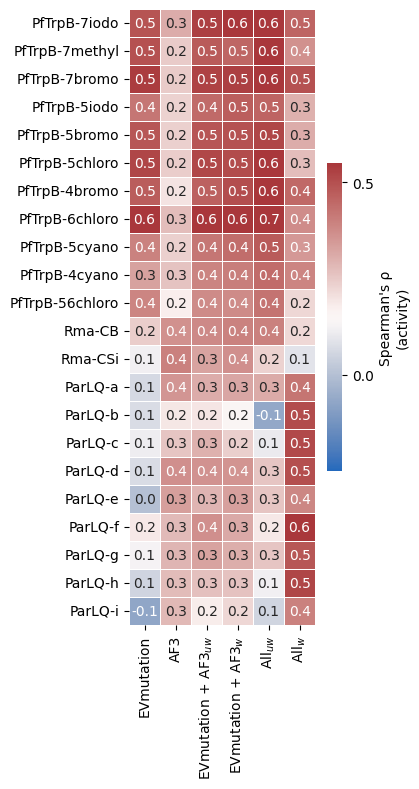

In [63]:
# Set the figure size
plt.figure(figsize=(3, 8))
# Create a heatmap
sns.heatmap(
    merged_df,
    # .reindex(LIB_ORDER),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={"label": "Spearman's ρ\n(activity)", "ticks": [0, 0.5], "shrink": 0.5},
    vmin=-0.25,
    vmax=0.55
)
# take away y label
plt.ylabel("")
# Show the plot
# plt.title("ZS Summary: Spearman correlation")
plt.savefig("figs/lincomb/zs_sumlincomb_fit_rho_all.svg", format="svg", dpi=300, bbox_inches="tight")

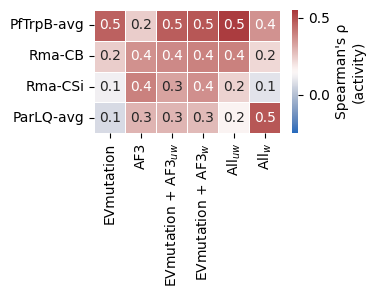

In [13]:
groups = {
    "PfTrpB-avg": [c for c in LIB_ORDER if c.startswith("PfTrpB")],
    "ParLQ-avg": [c for c in LIB_ORDER if c.startswith("ParLQ")],
}

for new_row, rows in groups.items():
    merged_df.loc[new_row] = merged_df.loc[rows].mean()

# Set the figure size
plt.figure(figsize=(3, 1.6))
# Create a heatmap
sns.heatmap(
    merged_df.loc[["PfTrpB-avg", "Rma-CB", "Rma-CSi", "ParLQ-avg"]],
    # .reindex(LIB_ORDER),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={"label": "Spearman's ρ\n(activity)", "ticks": [0, 0.5]},
    vmin=-0.25,
    vmax=0.55
)
# take away y label
plt.ylabel("")
# Show the plot
# plt.title("ZS Summary: Spearman correlation")
plt.savefig("figs/lincomb/zs_sumlincomb_fit_rho.svg", format="svg", dpi=300, bbox_inches="tight")

In [68]:
# do scatter plot for the best condition